In [2]:
import torch
from cnn_lstm import *
from preprocessing import *
from loop import *
import matplotlib.pyplot as plt

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device('cpu')
print(device)
# device = torch.device('cpu')

mps


In [5]:
def seed_everything(seed: int):
    import os
    import random

    import numpy as np
    import torch
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

In [14]:
train_dataloader, val_dataloader, test_dataloader = load_data(64)

Shape of training set: (14535, 22, 400)
Shape of validation set: (500, 22, 400)
Shape of training labels: (14535,)
Shape of validation labels: (500,)
Shape of training labels after categorical conversion: (1615,)
Shape of validation labels after categorical conversion: (500,)
Shape of test labels after categorical conversion: (443, 4)


In [26]:
seed_everything(0)

# (H - h + 2p) / s + 1
# 3 -> 1, 5 -> 2, 7 -> 3
kernel_size = 7
pad = 3

cnn_lstm_hybrid = cnn_lstm(kernel_size=kernel_size, pad=pad)

weight_decay = 1e-2

lr = 1e-3
optimizer = torch.optim.SGD(params=cnn_lstm_hybrid.parameters(), momentum=0.9, lr=lr)
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

# Train the model
history = train(cnn_lstm_hybrid,
      train_dataloader,
      val_dataloader,
      optimizer,
      criterion,
      device,
      num_epochs=50)

Epoch 1/50: 100%|██████████| 228/228 [00:05<00:00, 39.22it/s, accuracy=0.25, loss=0.0227] 


Validation set: Average loss = 1.3980, Accuracy = 0.2720


Epoch 2/50: 100%|██████████| 228/228 [00:05<00:00, 39.57it/s, accuracy=0.255, loss=0.0226]


Validation set: Average loss = 1.4409, Accuracy = 0.2280


Epoch 3/50: 100%|██████████| 228/228 [00:06<00:00, 36.20it/s, accuracy=0.257, loss=0.0227]


Validation set: Average loss = 1.5448, Accuracy = 0.2420


Epoch 4/50: 100%|██████████| 228/228 [00:06<00:00, 36.11it/s, accuracy=0.252, loss=0.0224]


Validation set: Average loss = 1.4699, Accuracy = 0.2420


Epoch 5/50: 100%|██████████| 228/228 [00:05<00:00, 39.54it/s, accuracy=0.252, loss=0.0223]


Validation set: Average loss = 1.3965, Accuracy = 0.2580


Epoch 6/50: 100%|██████████| 228/228 [00:05<00:00, 39.51it/s, accuracy=0.255, loss=0.0221]


Validation set: Average loss = 1.4048, Accuracy = 0.2420


Epoch 7/50: 100%|██████████| 228/228 [00:05<00:00, 38.78it/s, accuracy=0.246, loss=0.0222]


Validation set: Average loss = 1.4530, Accuracy = 0.2280


Epoch 8/50:   8%|▊         | 18/228 [00:00<00:06, 33.91it/s, accuracy=0.26, loss=0.022]  


KeyboardInterrupt: 

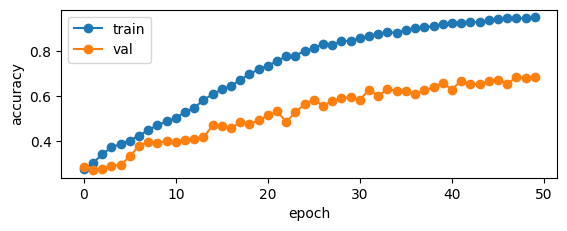

In [101]:
plt.subplot(2, 1, 1)
plt.plot(history['train_accuracy'], '-o')
plt.plot(history['val_accuracy'], '-o')
plt.legend(['train', 'val'], loc='upper left')
plt.ylabel('accuracy')
plt.xlabel('epoch')

# plt.subplot(2, 1, 2)
# plt.plot(history['train_loss'], '-o')
# plt.plot(history['val_loss'], '-o')
# plt.legend(['train', 'val'], loc='upper left')
# plt.ylabel('loss')
# plt.xlabel('epoch')
plt.show()

In [102]:
avg_loss, accuracy = evaluate(cnn_lstm_hybrid, test_dataloader, criterion, device)
print('Test Accuracy:', accuracy)

Test Accuracy: 0.6636568848758465


In [34]:
class test_lstm(nn.Module):

    def __init__(self, in_channels=22, in_length=400, conv_blocks=3, dims=[64, 128, 256], num_classes=4, kernel_size=7, stride=1, pad=3, dropout=0.5):
        super().__init__()
        
        self.conv_modules = nn.ModuleList()
        prev_channels = in_channels
        for i in range(conv_blocks):
            out_channels = dims[i]
            conv_block = nn.Sequential(
                nn.Conv1d(in_channels=prev_channels, out_channels=out_channels, kernel_size=kernel_size, stride=stride, padding=pad),
                nn.LeakyReLU(),
                nn.MaxPool1d(kernel_size=2, stride=2, padding=0),
                nn.BatchNorm1d(num_features=out_channels),
                nn.Dropout(dropout),
            )
            self.conv_modules.append(conv_block)
            prev_channels = out_channels
        
        # 400 -> 200 -> 100
        flatten_size = dims[-1] * (in_length // 2**conv_blocks)
        self.fc1 = nn.Linear(in_features=flatten_size, out_features=256)
        self.activation1 = nn.LeakyReLU()
        self.lstm = nn.LSTM(input_size=256, hidden_size=128, num_layers=1, batch_first=True, dropout=0.4)
        self.fc2 = nn.Linear(in_features=128, out_features=num_classes)

# (conv -> max -> batchnorm -> dropout) x 4
# flatten -> FC -> LSTM -> FC -> softmax

    def forward(self, x):
        for conv_module in self.conv_modules:
            x = conv_module(x)
        out = x.view(x.size(0), -1)
        out = self.fc1(out)
        out = self.activation1(out)
        out = out.unsqueeze(1)
        out, (h_n, n_n) = self.lstm(out)
        # Just use last hidden state
        out = self.fc2(h_n.squeeze(0))
        return out
    
    def compute_l1_loss(self):
        l1_loss = 0
        for param in self.parameters():
            l1_loss += torch.abs(param).sum()
        return l1_loss

In [36]:
seed_everything(0)

# (H - h + 2p) / s + 1
# 3 -> 1, 5 -> 2, 7 -> 3
kernel_size = 3
pad = 1

test_model = test_lstm(kernel_size=kernel_size, pad=pad)

weight_decay = 1e-2

lr = 1e-1
optimizer = torch.optim.SGD(params=test_model.parameters(), momentum=0.9, lr=lr)
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

# Train the model
history = train(test_model,
      train_dataloader,
      val_dataloader,
      optimizer,
      criterion,
      device,
      num_epochs=50)

Epoch 1/50:  58%|█████▊    | 59/101 [00:01<00:01, 29.94it/s, accuracy=0.408, loss=0.0578]


KeyboardInterrupt: 